# REINFORCE algorithm
# Policy Gradient based

## Using TF1.x
## Tested on CartPole-v0

In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
env = gym.make("CartPole-v0")

# gym compatibility: unwrap TimeLimit
if hasattr(env, '_max_episode_steps'):
    env = env.env

env.reset()
n_actions = env.action_space.n
state_dim = env.observation_space.shape

## Policy gradient algorithms
Given policy $\pi(a/s)$, we have expected discounted reward,

$$J = \mathbb{E}_{s-p(s), a-\pi_\theta(s/a)}G(s,a) $$

If we take J as the objective function and optimize our policy using gradient descent,

$$\theta_{i+1} \leftarrow \theta_{i} + \alpha*\nabla J$$
Where, $\theta$ is the policy parameters


In [3]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
sess = tf.InteractiveSession()

Instructions for updating:
non-resource variables are not supported in the long term


In [4]:
#Input variables, <S,A,R>
ph_states = tf.placeholder('float32', (None,) + state_dim, name="states")
ph_actions = tf.placeholder('int32', name="action_ids")
ph_cumulative_rewards = tf.placeholder('float32', name="cumulative_returns")

### Network

In [5]:
import tensorflow.compat.v1.keras as keras
from tensorflow.compat.v1.keras.layers import Dense, InputLayer

network = keras.Sequential()
network.add(InputLayer(state_dim))
network.add(Dense(200, activation='relu'))
network.add(Dense(200,activation='relu'))
network.add(Dense(n_actions))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [6]:
network.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 200)               1000      
_________________________________________________________________
dense_1 (Dense)              (None, 200)               40200     
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 402       
Total params: 41,602
Trainable params: 41,602
Non-trainable params: 0
_________________________________________________________________


## REINFORCE algorithm

#### Follows Policy gradient but with the following changes
##### Given the above objective function, we want its gradient
But this is often difficult directly over the policy, so use log-derivative trick to get policy gradient

$$\nabla \pi(z) = \pi(z)\nabla \log \pi(z)$$
##### This gives the following gradient function with MC sampled approximation
$$ \nabla_\theta \hat J(\theta) \approx { 1 \over N } \sum_{s_i, a_i} \nabla_\theta \log \pi_\theta (a_i \mid s_i) \cdot G_t(s_i, a_i) $$
##### Now, update network parameters theta using this gradient

In [7]:
#Our policy is the softmax activation over network output
#Since our actions are mutually exclusive-use softmax
logits = network(ph_states)
policy = tf.nn.softmax(logits)
#Log policy for cost gradient calculation
log_policy = tf.nn.log_softmax(logits)

In [8]:
def predict_probs(states):
    """ 
    Predict action probabilities given states.
    """
    return policy.eval({ph_states: [states.astype(np.float32)]})[0]

### Cumulative rewards
$$G_t= r_t + \gamma * G_{t + 1}$$

In [9]:
def get_cumulative_rewards(rewards,  # rewards at each step
                           gamma=0.99  # discount for reward
                           ):
    """
    Take a list of immediate rewards r(s,a) for the whole session 
    and compute cumulative returns (a.k.a. G(s,a) in Sutton '16).
    """
    rewards.reverse()
    cum_rewards = []
    cum_rewards.append(rewards[0])
    #Go through each reward
    for i in range(len(rewards)-1):
        cum_rewards.append(rewards[i+1] + gamma*cum_rewards[i])
    cum_rewards.reverse()
    return np.array(cum_rewards)

### Approximate Objective Function using MC

The above objective function gradient can be solved using tensorflow's gradient based optimization on this approx objective function below
##### Approx objective function
$$ \hat J(\theta) \approx { 1 \over N } \sum_{s_i, a_i} \log \pi_\theta (a_i \mid s_i) \cdot G_t(s_i, a_i) $$

When you compute the gradient of that function with respect to network weights $\theta$, it will become exactly the policy gradient.

In [12]:
#Select log pi(a_i/s_i) for the actions that were actually taken
indices = tf.stack([tf.range(tf.shape(log_policy)[0]), ph_actions], axis=-1)
log_policy_for_actions = tf.gather_nd(log_policy, indices)

In [14]:
#Objective function
J = tf.reduce_mean(log_policy_for_actions*ph_cumulative_rewards)

In [15]:
log_policy_for_actions

<tf.Tensor 'GatherNd_1:0' shape=(?,) dtype=float32>

### Entropy regularization
Without this, our policy will quickly tend to become deterministic

$$ H(p) = -\sum_{i = 1}^n p_i \cdot \log p_i $$

In [12]:
entropy = -tf.reduce_sum(policy*log_policy, axis=1)

### Loss function

In [13]:
lamb = 0.1 #entropy regularization parameter
loss = -(J + lamb*entropy)

In [14]:
update = tf.train.AdamOptimizer().minimize(loss)

## Sample Generation and Training

In [15]:
def generate_session(env, t_max=1000):
    """ 
    Play a full session with REINFORCE agent.
    """
    # arrays to record session
    states, actions, rewards = [], [], []
    s = env.reset()

    for t in range(t_max):
        # action probabilities array aka pi(a|s)       
        action_probs = predict_probs(s)
        # Sample action with given probabilities.
        a = np.random.choice(n_actions, p=action_probs)       
        new_s, r, done, info = env.step(a)
        # record session history to train later
        states.append(s)
        actions.append(a)
        rewards.append(r)
        s = new_s
        if done:
            break

    return states, actions, rewards

In [16]:
def train_on_session(states, actions, rewards, t_max=1000):
    """Given full session, trains agent with policy gradient"""
    cumulative_rewards = get_cumulative_rewards(rewards)
    update.run({
        ph_states: states,
        ph_actions: actions,
        ph_cumulative_rewards: cumulative_rewards,
    })
    return sum(rewards)

In [17]:
# Initialize optimizer parameters
sess.run(tf.global_variables_initializer())

# Train Time!

mean reward: 353.400 at iter: 3


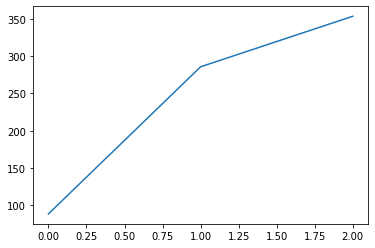

You Win!


In [20]:
from IPython.display import clear_output
rewards_log = []

for i in range(100):
    rewards = [train_on_session(*generate_session(env)) for _ in range(100)]  # generate new sessions
    rewards_log.append(np.mean(rewards))
    clear_output(True)
    print("mean reward: %.3f at iter:" % (np.mean(rewards)), i+1)
    plt.plot(rewards_log)
    plt.show()
    if np.mean(rewards) > 300:
        print("You Win!") 
        break

#### This actually works real fast for CartPole-v0, as can be seen by the number of iterations it actually took

In [21]:
# Record sessions
import gym.wrappers

with gym.wrappers.Monitor(gym.make("CartPole-v0"), directory="videos", force=True) as env_monitor:
    sessions = [generate_session(env_monitor) for _ in range(100)]

In [22]:
# Show video. This may not work in some setups. If it doesn't
# work for you, you can download the videos and view them locally.

from pathlib import Path
from IPython.display import HTML

video_names = sorted([s for s in Path('videos').iterdir() if s.suffix == '.mp4'])

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format(video_names[-1]))  # You can also try other indices